In [1]:
import os
import cdsapi

import json
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9
import seaborn as sns

In [2]:
from tqdm.auto import tqdm
from collections import defaultdict
#from sdcpy.scale_dependent_correlation import SDCAnalysis
import warnings

c:\Users\brand\anaconda3\envs\tfm_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## SDC Analysis for groups of contiguous countries

In [86]:
world = pd.read_pickle('../data/world_shape.pkl')

In [87]:
country_to_iso = world[['country', 'iso3']].drop_duplicates()

In [88]:
covid_df = pd.read_csv('../data/covid/covid19_world.csv')

In [89]:
country_groups = pd.read_csv('../data/country_groups.csv')

In [90]:
lon_lat_country = pd.read_csv('../data/coords_region_0.5.csv').merge(country_to_iso)

In [91]:
lon_lat_group = lon_lat_country.merge(country_groups)

In [92]:
processed_path = "../data/climate/grid_0.5/processed/"
relevant_files = [f for f in os.listdir(processed_path) if (f[:9] >= '2021_12_0') & (f[:9] <= '2022_12_2')]
climate_df = pd.concat([pd.read_pickle(f'{processed_path}{f}') for f in relevant_files])

In [93]:
if not os.path.exists('../data/processed_05_grid.csv'):
    dens = (
        xr.load_dataset("../data/gpw_v4_population_density_rev11_2pt5_min.nc")
        .sel({"raster": 4})
        .to_dataframe()
        .dropna()
        .reset_index()
        .drop(columns="raster")
        .rename(
            columns={
                "Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes": "density"
            }
        )
        # Rounding to closest .5 degree
        .assign(latitude=lambda dd: (dd.latitude * 2).round() / 2)
        .assign(longitude=lambda dd: (dd.longitude * 2).round() / 2)
        .groupby(["latitude", "longitude"])
        .mean()
        .reset_index()
    )

    dens.to_csv('../data/processed_05_grid.csv', index=False)
dens = pd.read_csv("../data/processed_05_grid.csv")

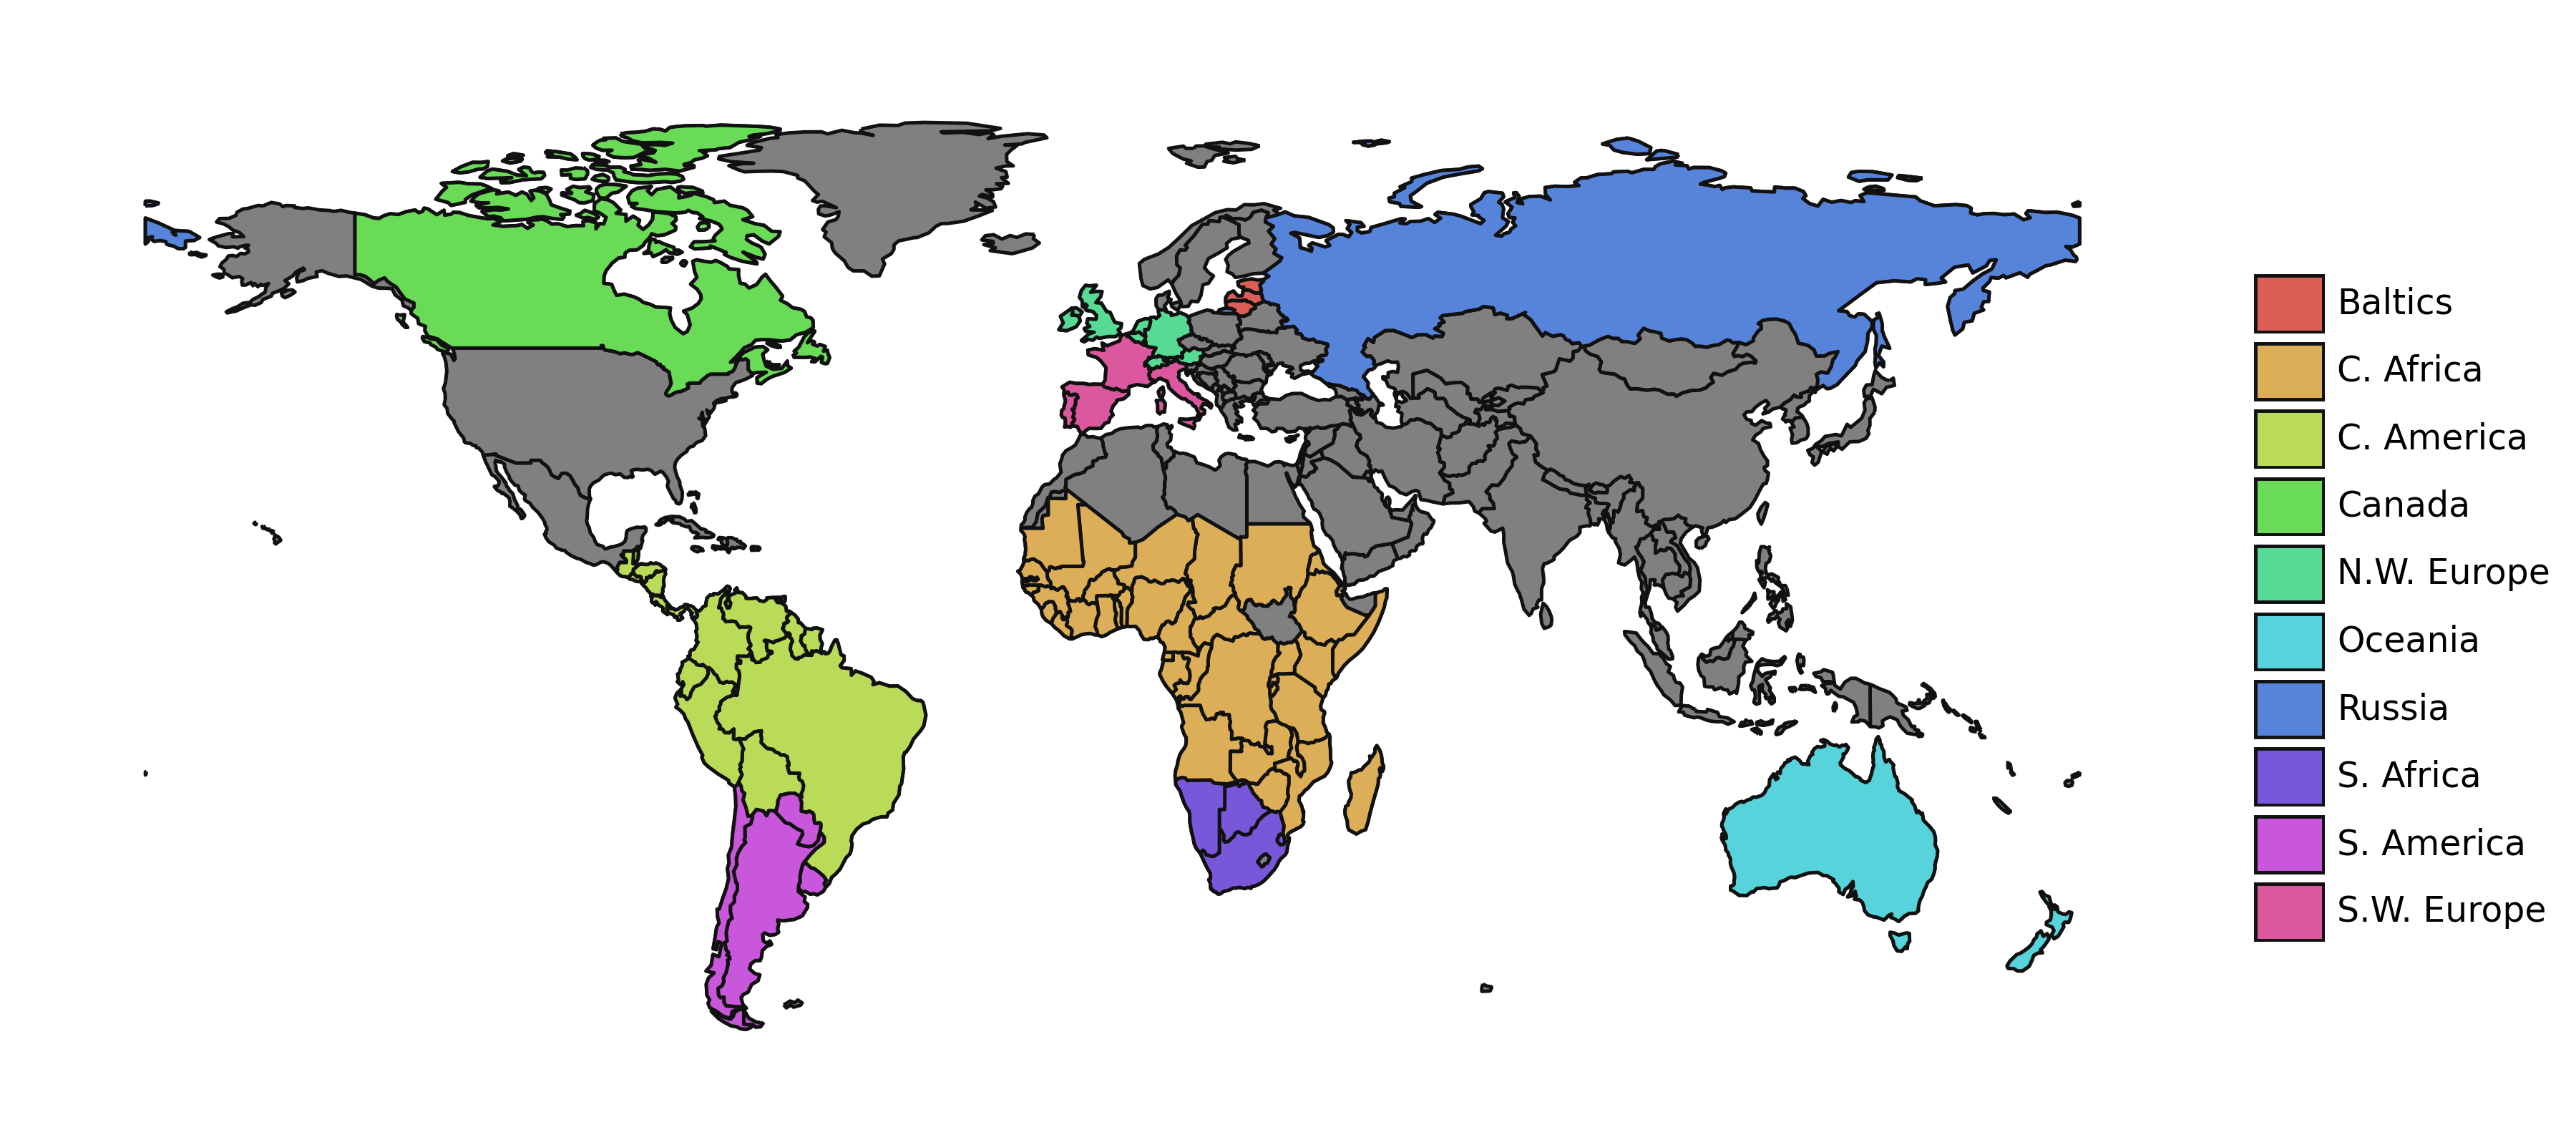

<Figure Size: (1800 x 800)>

In [94]:
f = (world
     .merge(country_groups)
     .pipe(lambda dd: p9.ggplot(dd)
       + p9.geom_map(data=world, fill='gray')
       + p9.geom_map(p9.aes(fill='group'))
       + p9.ylim(-55, None)
       + p9.labs(fill='')
       + p9.theme_void()
       + p9.theme(figure_size=(9, 4), dpi=200, legend_key_height=15)
      )
)
f

In [95]:
weighted_cells = (dens.merge(lon_lat_group)
    .groupby('group', as_index=False)
    .apply(lambda gdd: gdd.assign( relative_weight=lambda gdd: gdd.density / gdd.density.sum()))
    .reset_index(drop=True)
)

C:\Users\brand\AppData\Local\Temp\ipykernel_34372\1766496956.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [96]:
weighted_climate_df = (
        weighted_cells.dropna()
        .merge(climate_df, on=["latitude", "longitude"])
        .assign(temperature=lambda dd: dd.temperature * dd.relative_weight,
                absolute_humidity=lambda dd: dd.absolute_humidity * dd.relative_weight)
        .groupby(['group', "date"], as_index=False)
        [["temperature", "absolute_humidity"]]
        .agg({"temperature": "sum", "absolute_humidity": "sum"})
)

In [97]:
groups_covid_ts = \
(covid_df
 .merge(country_groups)
 .assign(date=lambda dd: pd.to_datetime(dd.date))
 .groupby('group')
 .apply(lambda dd: 
        dd.set_index('date')
        .resample('D')
        .sum()
        ['new_cases']
        #.rolling(center=True, window=7)
        #.mean()
        .loc['2021-12-01': '2022-12-31'])
)

C:\Users\brand\AppData\Local\Temp\ipykernel_34372\1085163371.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [ ]:
groups_weather_ts = \
(weighted_climate_df
 .assign(date=lambda dd: pd.to_datetime(dd.date))
 .query('"2021-12-01" <= date <= "2022-12-31"')
 .set_index(['group', 'date'])
)

In [ ]:
CV_LABELS = {'absolute_humidity': 'Absolute Humidity [g/m³]',
             'temperature': 'Temperature [°C]',
             'relative_humidity': 'Relative Humidity [%]',
             'total_precipitation': 'Total Precipitation [mm]'}

In [ ]:
import openpyxl
from sdcpy.scale_dependent_correlation import SDCAnalysis

w = 100
out_dir = '../results'
for group in tqdm(country_groups.group.unique(), desc='Processing Groups', leave=False):
    for weather_variable in ['temperature', 'absolute_humidity']:
        covid_ts = groups_covid_ts.loc[group]
        weather_ts = groups_weather_ts.loc[group][weather_variable]
        sdc = SDCAnalysis(ts1=weather_ts,
                          ts2=covid_ts,
                          fragment_size=w,
                          method='spearman',
                          max_lag=0,
                          min_lag=-21)
        sdc.to_excel(f"{out_dir}/tables/SDC_country_groups/sdc_{w}_{group}_{weather_variable}.xlsx")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sdc.combi_plot(dpi=120,
                           figsize=(7, 7),
                           title=f"SDC with s={w}: \nCOVID19 daily confirmed cases in" +
                                 f" {group} ~ {weather_variable}",
                           xlabel=CV_LABELS[weather_variable],
                           ylabel=f"Confirmed COVID19 cases in {group}",
                           alpha=0.05,
                           max_lag=0,
                           min_lag=-21,
                           max_r=1,
                           wspace=.35,
                           hspace=.35)
        plt.savefig(f"{out_dir}/figures/SDC_country_groups/sdc_{w}_{group}_{weather_variable}.png")
        plt.savefig(f"{out_dir}/figures/SDC_country_groups/sdc_{w}_{group}_{weather_variable}.pdf")
        

## SDC Analysis for European countries

In [127]:
eur_countries = lon_lat_country[lon_lat_country['country'].isin(['Germany', 'Spain', 'France', 'United Kingdom', 'Italy', 'Mexico'])]

In [128]:
eur_covid_ts = (
    covid_df
    .query("country in ['Germany', 'Spain', 'France', 'United Kingdom', 'Italy', 'Mexico']")
    .assign(date=lambda dd: pd.to_datetime(dd['date']))
    .set_index('date')
    .sort_index()
    [['country','new_cases']]
    .loc['2021-12-01':'2022-12-31']
)

In [129]:
eur_weighted_cells = (dens.merge(lon_lat_country)
    .groupby('country', as_index=False)
    .apply(lambda gdd: gdd.assign( relative_weight=lambda gdd: gdd.density / gdd.density.sum()))
    .reset_index(drop=True)
)

C:\Users\brand\AppData\Local\Temp\ipykernel_34372\3096511853.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [130]:
eur_weighted_climate_df = (
        eur_weighted_cells.dropna()
        .merge(climate_df, on=["latitude", "longitude"])
        .assign(temperature=lambda dd: dd.temperature * dd.relative_weight,
                absolute_humidity=lambda dd: dd.absolute_humidity * dd.relative_weight)
        .groupby(["date","country_x"], as_index=False)
        [["temperature", "absolute_humidity"]]
        .agg({"temperature": "sum", "absolute_humidity": "sum"})
)

In [131]:
eur_weather_ts = (
    eur_weighted_climate_df
    .query("country_x in ['Germany', 'Spain', 'France', 'United Kingdom', 'Italy', 'Mexico']")
    .assign(date=lambda dd: pd.to_datetime(dd['date']))
    .query('"2021-12-01" <= date <= "2022-12-31"')
    .set_index('date')
)

In [103]:
CV_LABELS = {'absolute_humidity': 'Absolute Humidity [g/m³]',
             'temperature': 'Temperature [°C]',
             'relative_humidity': 'Relative Humidity [%]',
             'total_precipitation': 'Total Precipitation [mm]'}

In [132]:
from sdc_modified import SDCAnalysis
w = 105
out_dir = '../results'
#for country in tqdm(['Germany', 'Spain', 'France', 'United Kingdom', 'Italy'], desc='Processing Countries', leave=False):
for country in tqdm(['Mexico'], desc='Processing Countries', leave=False):
    for weather_variable in ['temperature', 'absolute_humidity']:
        country_covid_ts = eur_covid_ts[eur_covid_ts['country'] == country]['new_cases']
        country_weather_ts = eur_weather_ts[eur_weather_ts['country_x'] == country][weather_variable]
        sdc = SDCAnalysis(ts1=country_weather_ts,
                          ts2=country_covid_ts,
                          fragment_size=w,
                          method='spearman',
                          max_lag=0,
                          min_lag=-21)
        sdc.to_excel(f"{out_dir}/tables/SDC_eur_countries/sdc_{w}_{country}_{weather_variable}.xlsx")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sdc.combi_plot(dpi=120,
                           figsize=(7, 7),
                           title=f"SDC with s={w}: \nCOVID19 daily confirmed cases in" +
                                 f" {country} ~ {weather_variable}",
                           xlabel=CV_LABELS[weather_variable],
                           ylabel=f"Confirmed COVID19 cases in {country}",
                           alpha=0.05,
                           max_lag=0,
                           min_lag=-21,
                           max_r=1,
                           wspace=.35,
                           hspace=.35)
        plt.savefig(f"{out_dir}/figures/SDC_eur_countries/sdc_{w}_{country}_{weather_variable}.png")
        plt.savefig(f"{out_dir}/figures/SDC_eur_countries/sdc_{w}_{country}_{weather_variable}.pdf")
        plt.close()

## SDC Analysis for EU regions

In [48]:
lon_lat_region = pd.read_csv('../data/coords_region_EU_regions.csv')

In [49]:
covid_eu = pd.read_csv('../data/covid/covid_eu.csv')

In [50]:
processed_path = "../data/climate/grid_0.25/processed/"
relevant_files = [f for f in os.listdir(processed_path) if (f[:9] >= '2021_12_0') & (f[:9] <= '2022_12_2')]
eu4_weather = pd.concat([pd.read_pickle(f'{processed_path}{f}') for f in relevant_files])

In [51]:
dens = (
    xr.load_dataset("../data/gpw_v4_population_density_rev11_2pt5_min.nc")
    .sel({"raster": 4})
    .to_dataframe()
    .dropna()
    .reset_index()
    .drop(columns="raster")
    .rename(
        columns={
            "Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes": "density"
        }
    )
    # Here I am first, rounding up to .25 resolution and then shifting the map so that longitudes
    # are on the -180 +180 domain. 
    .assign(latitude=lambda dd: (dd.latitude * 4).round() / 4)
    .assign(longitude=lambda dd: (dd.longitude * 4).round() / 4)
    .groupby(["latitude", "longitude"])
    .mean()
    .reset_index()
)

In [52]:
weighted_cells = (
    dens.merge(lon_lat_region)
    .groupby('region', as_index=False)
    .apply(
        lambda gdd: gdd.assign(
            relative_weight=lambda gdd: gdd.density / gdd.density.sum()
        )
    )
    .reset_index(drop=True)
)

C:\Users\brand\AppData\Local\Temp\ipykernel_34372\433515362.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [53]:
weighted_climate_df = (
    weighted_cells
    .dropna()
    .merge(eu4_weather.merge(lon_lat_region), on=["latitude", "longitude", "region"])
    .assign(
        temperature=lambda dd: dd.temperature * dd.relative_weight,
        absolute_humidity=lambda dd: dd.absolute_humidity * dd.relative_weight
    )
    .groupby(['region', "date"])
    .agg({"temperature": "sum",
          "absolute_humidity": "sum",
          "relative_humidity": "sum",
          "total_precipitation": "sum"})
    .reset_index()
    .assign(region=lambda dd: dd.region.replace({'Valle d’Aosta/Vallée d’Aoste': "Valle d'Aosta"}))
    .melt(['region', 'date'])
    .assign(region=lambda dd: dd.region.str.replace('/', '-'))
    .sort_values(['region', 'date'])
    
)

In [54]:
covid_sdc_df = (covid_eu
                .query('"2021-12-01" <= date <= "2022-12-31"')
                .loc[lambda dd: dd.region.isin(weighted_climate_df.region.unique())]
)

In [55]:
covid_sdc_df[covid_sdc_df['iso3']=='FRA'].region.unique()

array(['Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne',
       'Centre — Val de Loire', 'Corse', 'Grand Est', 'Hauts-de-France',
       'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire',
       'Provence-Alpes-Côte d’Azur', 'Ile-de-France'], dtype=object)

In [56]:
with open('../data/regions_country.json', 'r') as json_file:
    regions_country = json.load(json_file)

In [ ]:
from sdc_modified import SDCAnalysis

ranges_df = []
errors_list = {}
window = 14
sdcs = {}

for region in covid_sdc_df.region.unique():
    country = regions_country[region]
    for var in ['temperature', 'absolute_humidity']:
            
            w = (weighted_climate_df
                 .query(f'region=="{region}" & variable=="{var}"')
                 .set_index('date')
                 .value)

            c = (covid_sdc_df
                 .query(f'region=="{region}"')
                 .set_index('date')
                 .new_cases
                 .rolling(center=True, window=7)
                 .mean()
                 .dropna())
     
            # Ensure the indices are in datetime format
            w.index = pd.to_datetime(w.index)
            c.index = pd.to_datetime(c.index)   
        
            bin_size = 2 if var == 'absolute_humidity' else 3
            max_bin = 22 if var == 'absolute_humidity' else 32
            min_bin = 0 if var == 'absolute_humidity' else -6
            sdc = SDCAnalysis(w, c, fragment_size=window, min_lag=-21, max_lag=0, method='spearman')
           
            sdcs[f'{region}_{var}'] = sdc

            ranges_df.append(sdc.get_ranges_df(bin_size=bin_size, max_bin=max_bin, min_bin=min_bin)
                                      .assign(region=region, var=var, country=regions_country[region]
                                              ))
            print("Get Ranges Done")

In [59]:
ranges_df = pd.concat(ranges_df)
ranges_df.to_csv('../results/tables/ranges_eu_regions.csv', index=False)

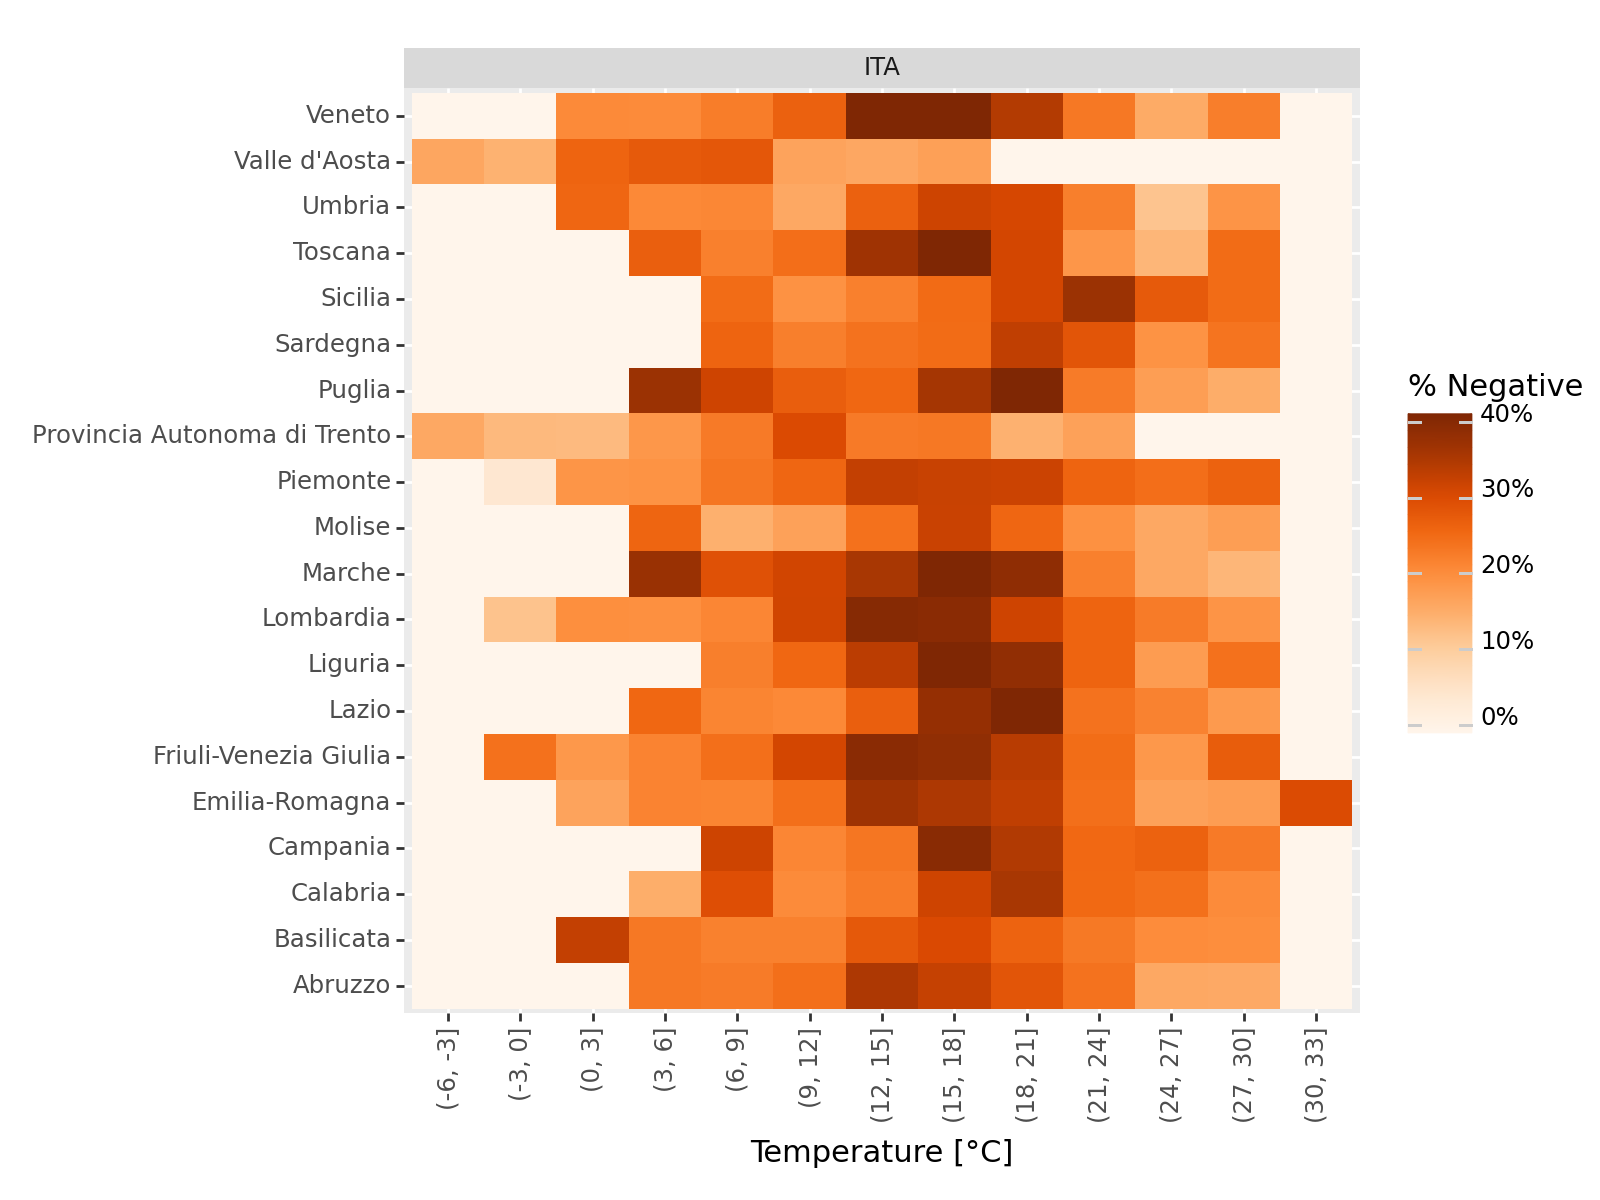

<Figure Size: (800 x 600)>

In [118]:
from mizani.formatters import date_format, percent_format

CV_LABELS = {'absolute_humidity': 'Absolute Humidity [g/m³]',
             'temperature': 'Temperature [°C]',
             'relative_humidity': 'Relative Humidity [%]',
             'total_precipitation': 'Total Precipitation [mm]'}

wv = 'temperature'

(ranges_df
 .loc[lambda dd: dd['var']==wv]
 .loc[lambda dd: dd.direction=='Negative']
 .loc[lambda dd: dd.country=='ITA']
 .groupby(['cat_value', 'region', 'country'])
 [['n', 'counts']]
 .sum()
 .reset_index()
 .assign(freq=lambda dd: (dd['counts'] / dd['n']).fillna(0))
  .pipe(lambda dd: p9.ggplot(dd)
               + p9.aes('cat_value', 'region', fill='freq')
               + p9.geom_tile()
               + p9.facet_wrap('country', ncol=1, scales='free_y')
               + p9.theme(figure_size=(8, 6), axis_text_x=p9.element_text(rotation=90))
               + p9.scale_fill_continuous('Oranges', labels=percent_format(), limits=(0, .4))
               + p9.labs(x=CV_LABELS[wv], fill='% Negative', y='')
               )
)

C:\Users\brand\AppData\Local\Temp\ipykernel_34372\156443267.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
c:\Users\brand\anaconda3\envs\tfm_env\Lib\site-packages\plotnine\scales\scale_manual.py:45: PlotnineWarning: The palette of scale_fill_manual can return a maximum of 2 values. 3 were requested from it.
c:\Users\brand\anaconda3\envs\tfm_env\Lib\site-packages\plotnine\scales\scale_manual.py:45: PlotnineWarning: The palette of scale_fill_manual can return a maximum of 2 values. 3 were requested from it.


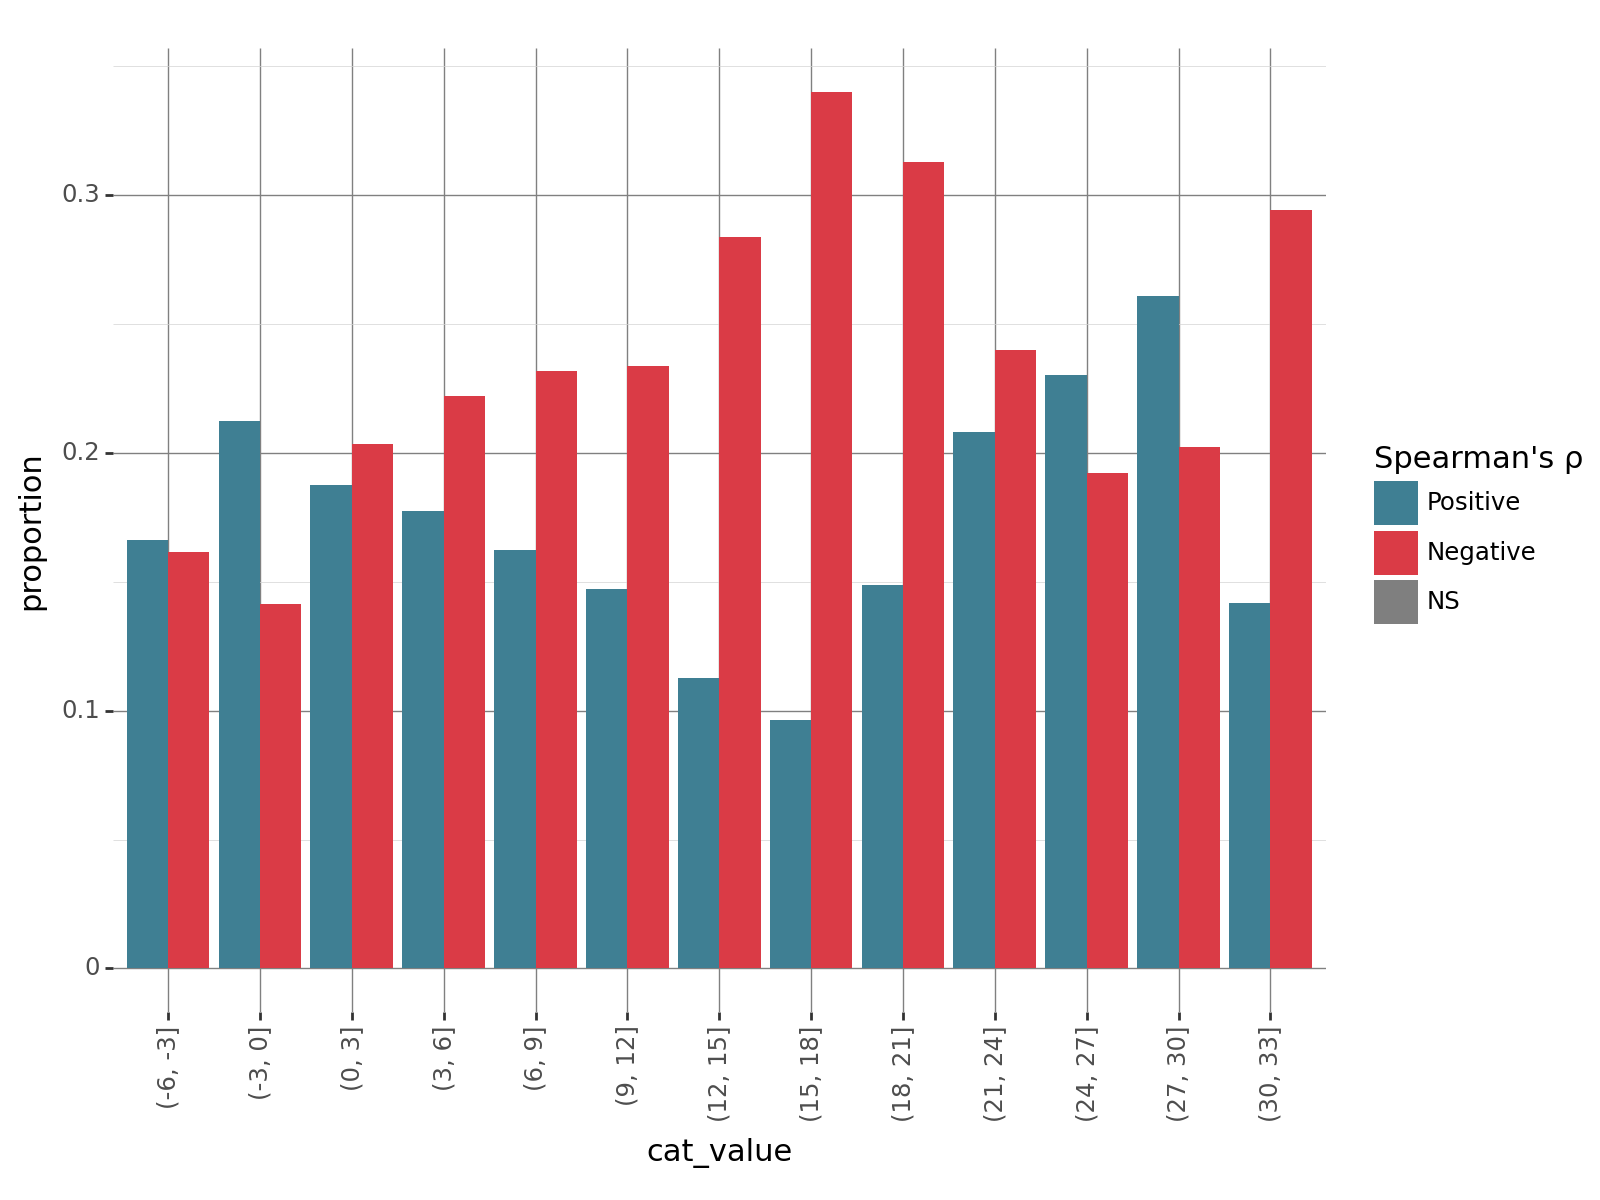

In [123]:
# Filter data for Italy and temperature
df_italy_temp = ranges_df[(ranges_df['country'] == 'ITA') & (ranges_df['var'] == 'temperature')]

# Calculate proportions of each direction within each temperature range
df_proportions = (df_italy_temp
                  .groupby(['cat_value', 'direction'])
                  .agg({'counts': 'sum', 'n': 'sum'})
                  .reset_index()
                  .assign(proportion=lambda x: x['counts'] / x['n'])
                 )
df_proportions = df_proportions[df_proportions['direction'] != 'NS']

direction_colors = {
    'Negative': '#da3b46',
    'Positive': '#3f7f93',
}

# Create the bar plot
plot = (p9.ggplot(df_proportions)
        + p9.aes(x='cat_value', y='proportion', fill='direction')
        + p9.geom_bar(stat='identity', position='dodge')
        + p9.scale_fill_manual(values=direction_colors)
        + p9.theme(
            figure_size=(8, 6),
            axis_text_x=p9.element_text(rotation=90),
            panel_background=p9.element_rect(fill='white'),
            panel_grid_major=p9.element_line(color='grey', size=0.5),
            panel_grid_minor=p9.element_line(color='lightgrey', size=0.25)
        )
        + p9.labs(fill="Spearman's ρ")
       )

# Display the plot
print(plot)

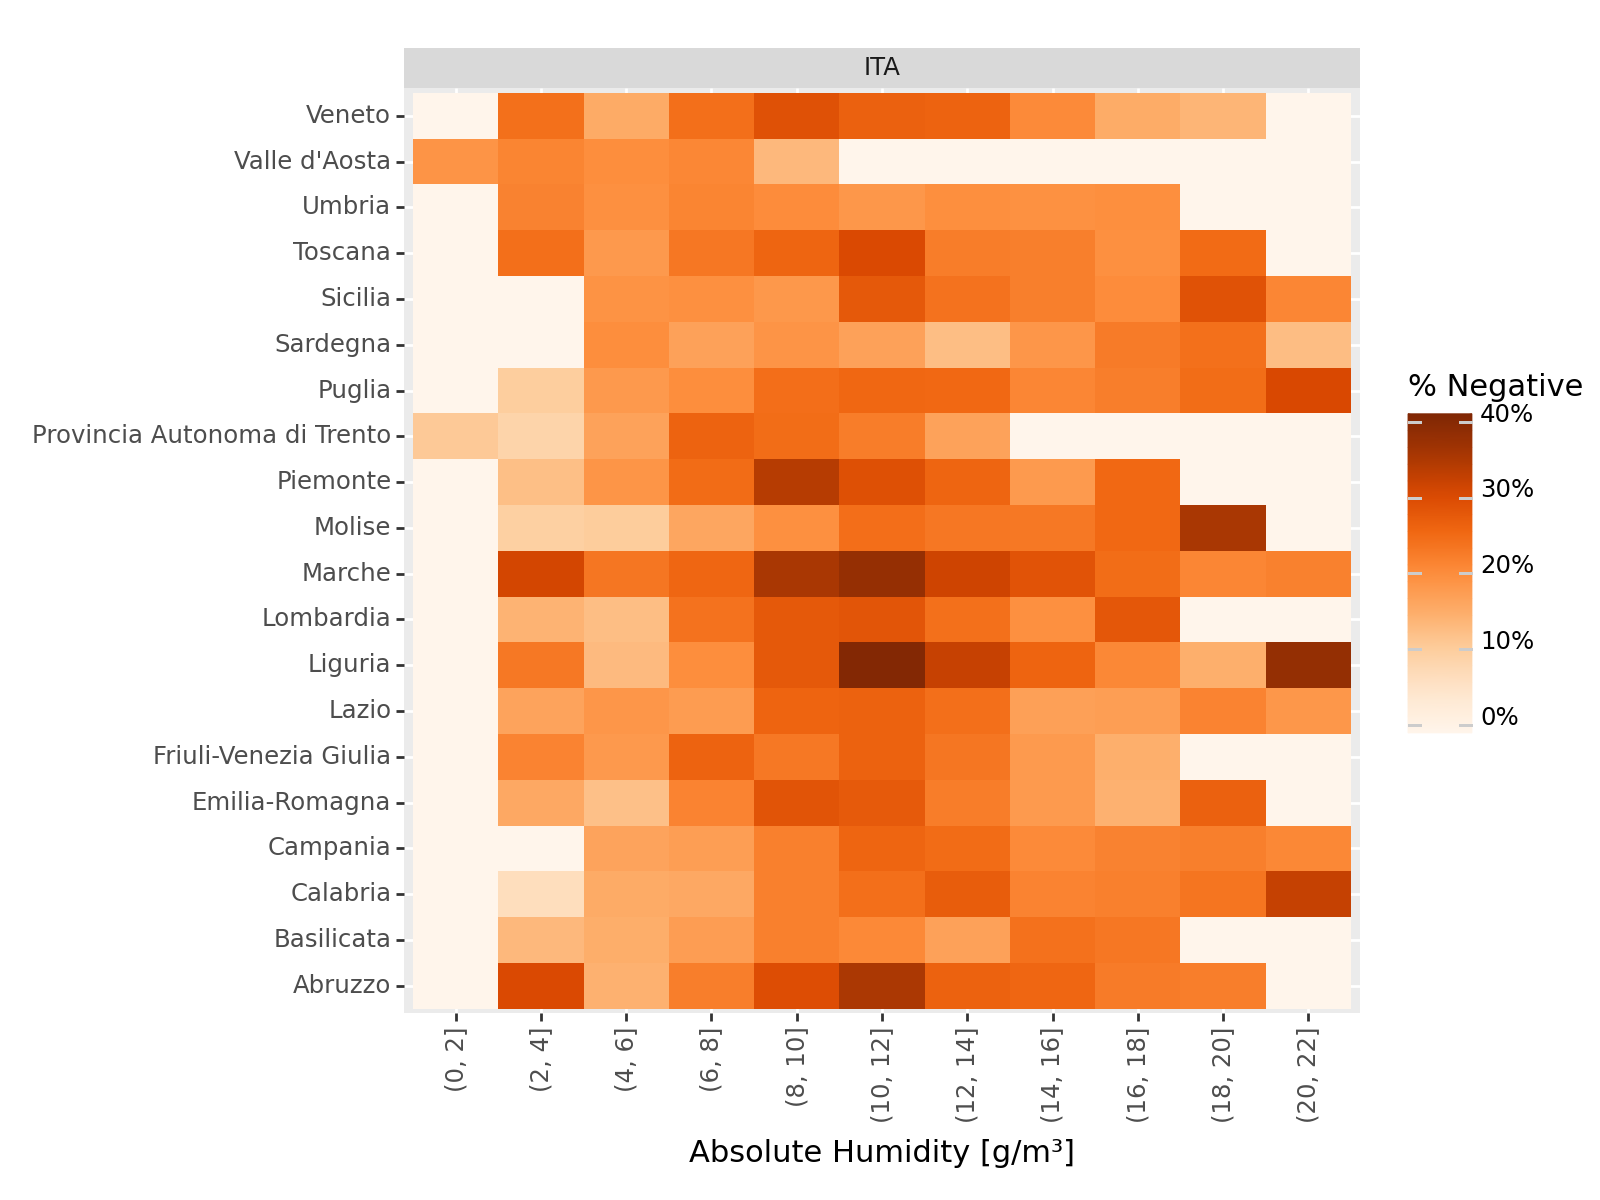

<Figure Size: (800 x 600)>

In [121]:
from mizani.formatters import date_format, percent_format

CV_LABELS = {'absolute_humidity': 'Absolute Humidity [g/m³]',
             'temperature': 'Temperature [°C]',
             'relative_humidity': 'Relative Humidity [%]',
             'total_precipitation': 'Total Precipitation [mm]'}

wv = 'absolute_humidity'

(ranges_df
 .loc[lambda dd: dd['var']==wv]
 .loc[lambda dd: dd.direction=='Negative']
 .loc[lambda dd: dd.country=='ITA']
 .groupby(['cat_value', 'region', 'country'])
 [['n', 'counts']]
 .sum()
 .reset_index()
 .assign(freq=lambda dd: (dd['counts'] / dd['n']).fillna(0))
  .pipe(lambda dd: p9.ggplot(dd)
               + p9.aes('cat_value', 'region', fill='freq')
               + p9.geom_tile()
               + p9.facet_wrap('country', ncol=1, scales='free_y')
               + p9.theme(figure_size=(8, 6), axis_text_x=p9.element_text(rotation=90))
               + p9.scale_fill_continuous('Oranges', labels=percent_format(), limits=(0, .4))
               + p9.labs(x=CV_LABELS[wv], fill='% Negative', y='')
               )
)

C:\Users\brand\AppData\Local\Temp\ipykernel_34372\3451913297.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
c:\Users\brand\anaconda3\envs\tfm_env\Lib\site-packages\plotnine\scales\scale_manual.py:45: PlotnineWarning: The palette of scale_fill_manual can return a maximum of 2 values. 3 were requested from it.
c:\Users\brand\anaconda3\envs\tfm_env\Lib\site-packages\plotnine\scales\scale_manual.py:45: PlotnineWarning: The palette of scale_fill_manual can return a maximum of 2 values. 3 were requested from it.


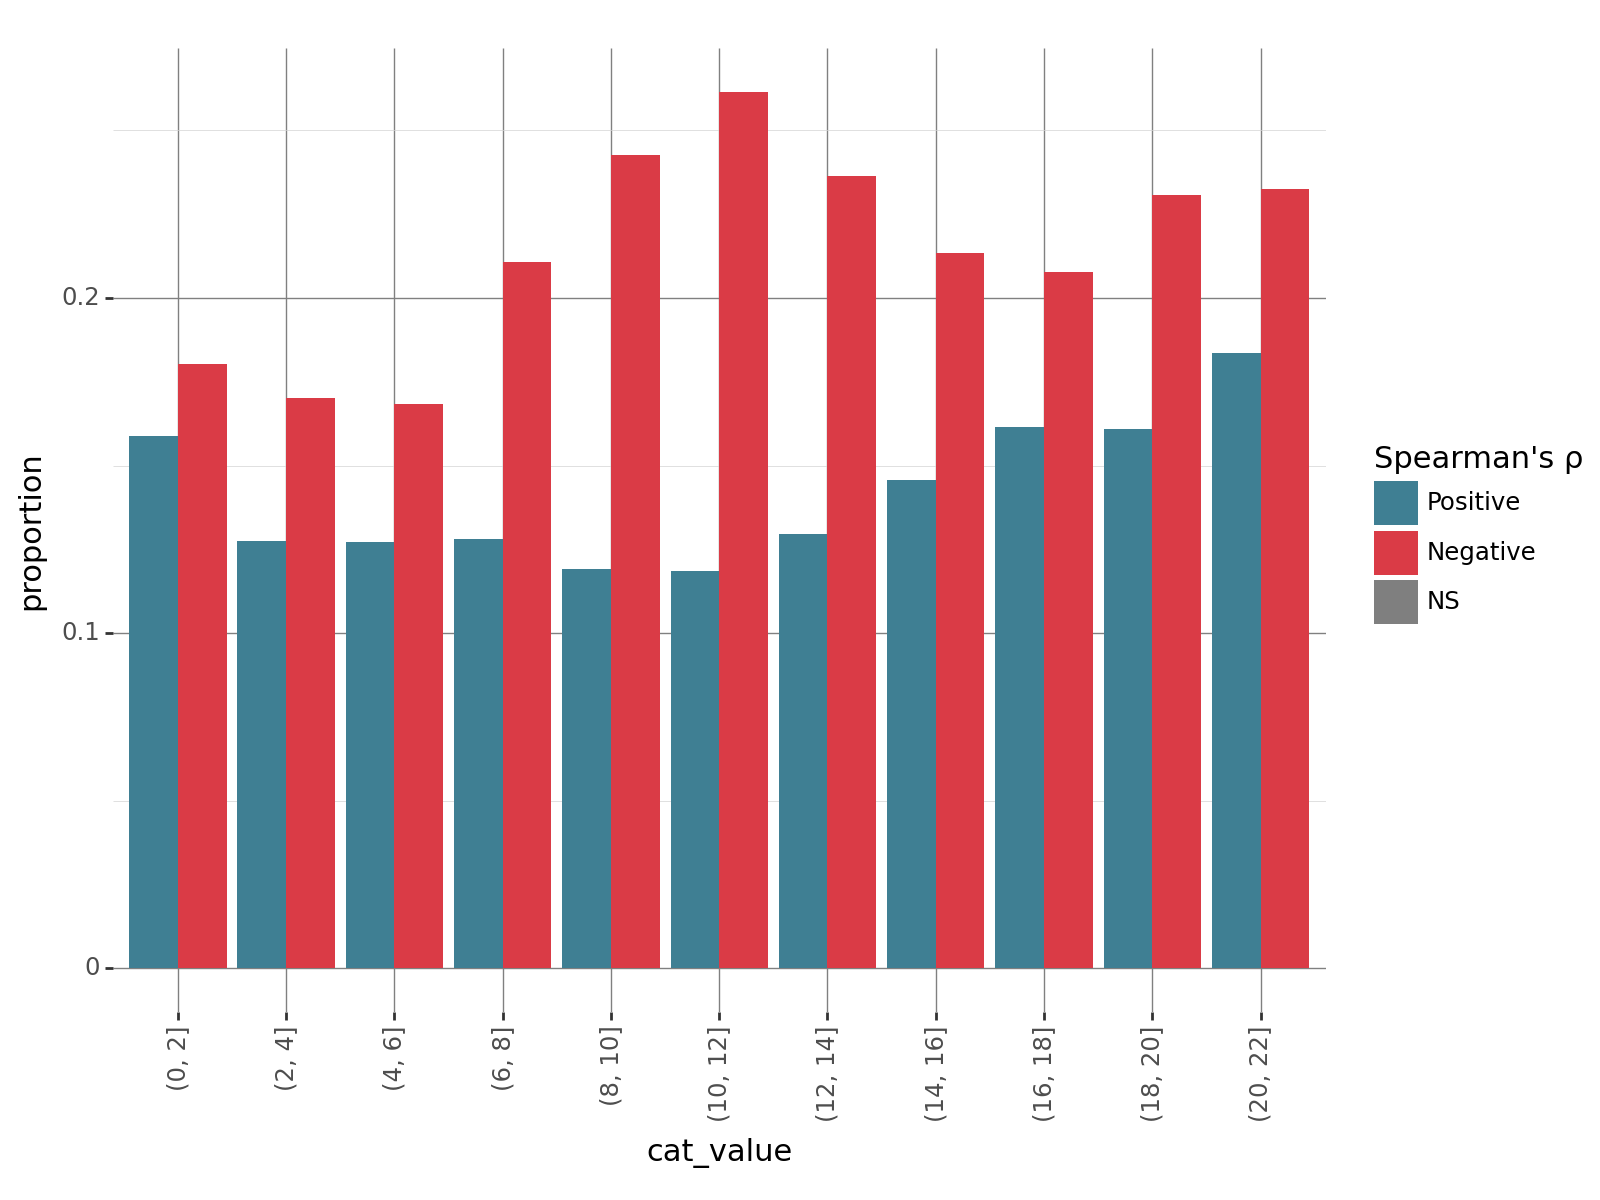

In [84]:
df_italy_ah = ranges_df[(ranges_df['country'] == 'ITA') & (ranges_df['var'] == 'absolute_humidity')]

df_proportions = (df_italy_ah
                  .groupby(['cat_value', 'direction'])
                  .agg({'counts': 'sum', 'n': 'sum'})
                  .reset_index()
                  .assign(proportion=lambda x: x['counts'] / x['n'])
                 )
df_proportions = df_proportions[df_proportions['direction'] != 'NS']

direction_colors = {
    'Negative': '#da3b46',
    'Positive': '#3f7f93',
}

plot = (p9.ggplot(df_proportions)
        + p9.aes(x='cat_value', y='proportion', fill='direction')
        + p9.geom_bar(stat='identity', position='dodge')
        + p9.scale_fill_manual(values=direction_colors)
        + p9.theme(
            figure_size=(8, 6),
            axis_text_x=p9.element_text(rotation=90),
            panel_background=p9.element_rect(fill='white'),
            panel_grid_major=p9.element_line(color='grey', size=0.5),
            panel_grid_minor=p9.element_line(color='lightgrey', size=0.25)
        )
        + p9.labs(fill="Spearman's ρ")
       )

print(plot)

C:\Users\brand\AppData\Local\Temp\ipykernel_34372\4211070705.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


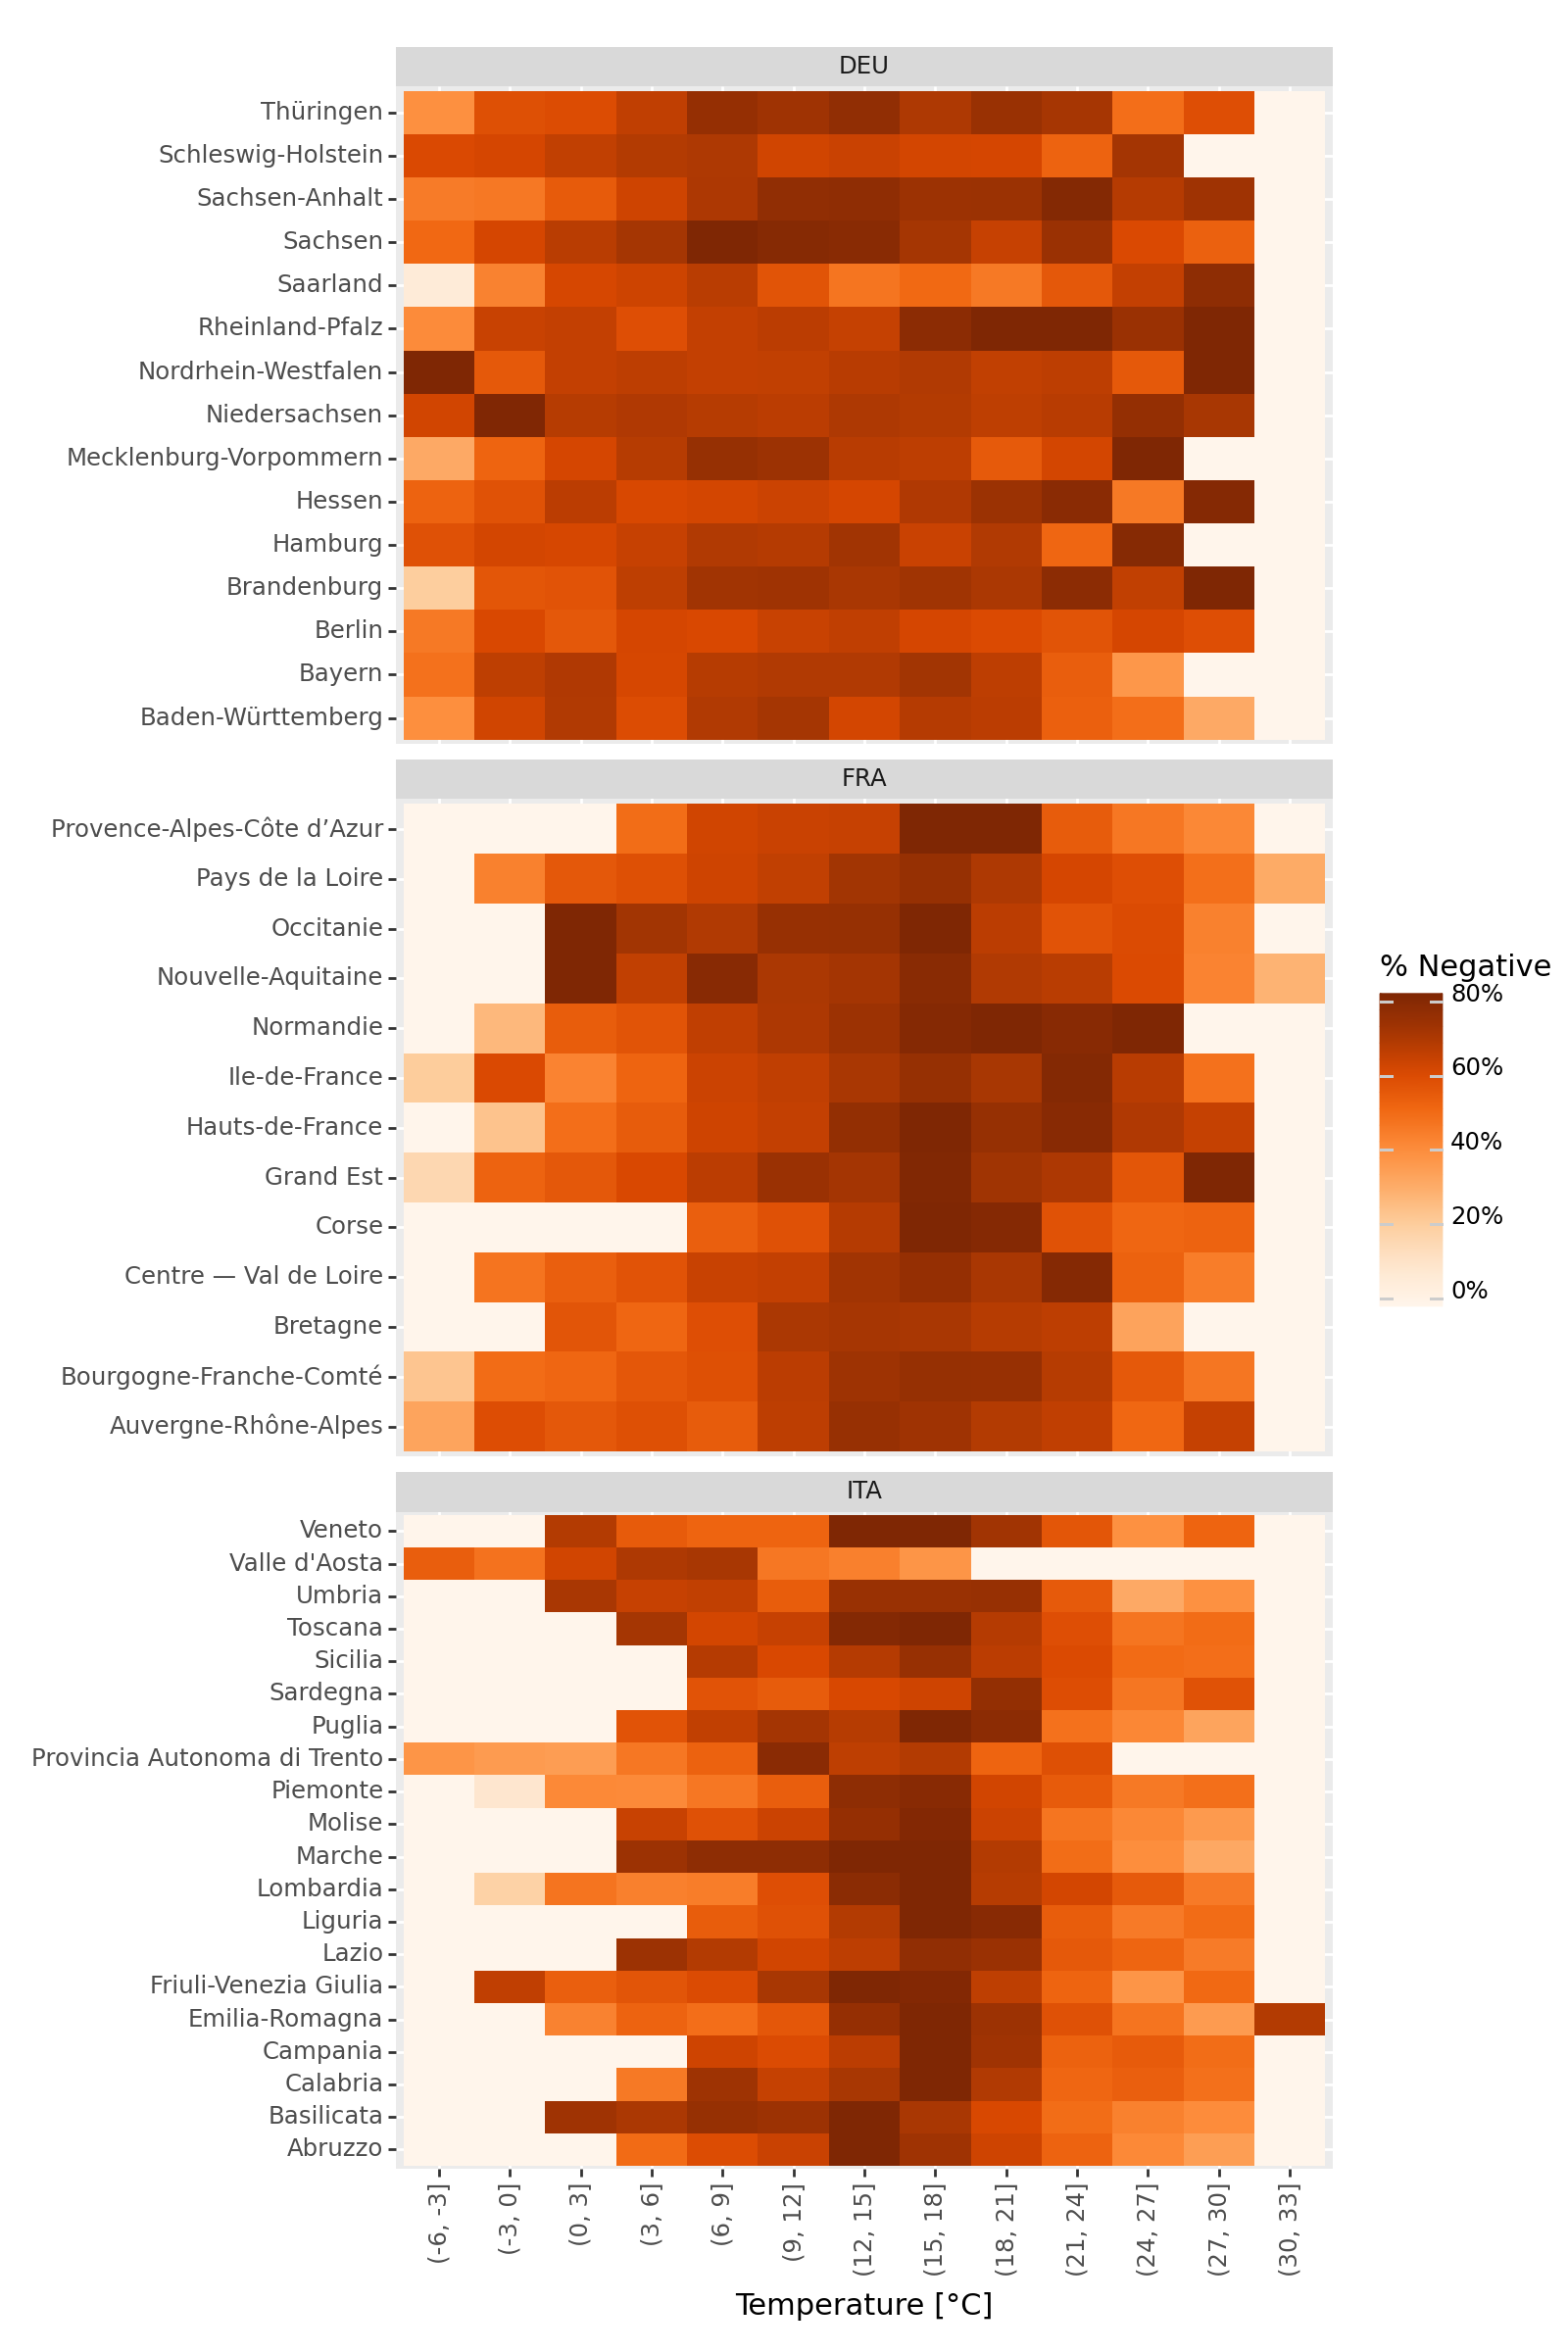

<Figure Size: (800 x 1200)>

In [66]:
wv = 'temperature'

(
    ranges_df
    .loc[lambda dd: (dd['var'] == wv)]  # Filter by variable of interest
    .groupby(['cat_value', 'region', 'country'])
    .apply(lambda x: x.assign(n=x.loc[x['direction'] != 'NS', 'counts'].sum()))  # Calculate n excluding 'NS'
    .reset_index(drop=True)
    .assign(negative=lambda dd: dd.loc[dd['direction'] == 'Negative', 'counts'] / dd['n'])  # Calculate % Negative
    .loc[lambda dd: dd['direction'] == 'Negative']  # Filter for Negative direction only
    .fillna(value={'negative': 0})  # Replace NaN with 0 for % Negative
    .pipe(lambda dd: p9.ggplot(dd)
         + p9.aes('cat_value', 'region', fill='negative')
         + p9.geom_tile()
         + p9.facet_wrap('country', ncol=1, scales='free_y')
         + p9.theme(figure_size=(8, 12), axis_text_x=p9.element_text(rotation=90))
         + p9.scale_fill_continuous('Oranges', labels=percent_format(), limits=(0, 0.8))
         + p9.labs(x=CV_LABELS[wv], fill='% Negative', y='')
         )
)

C:\Users\brand\AppData\Local\Temp\ipykernel_34372\2410581835.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


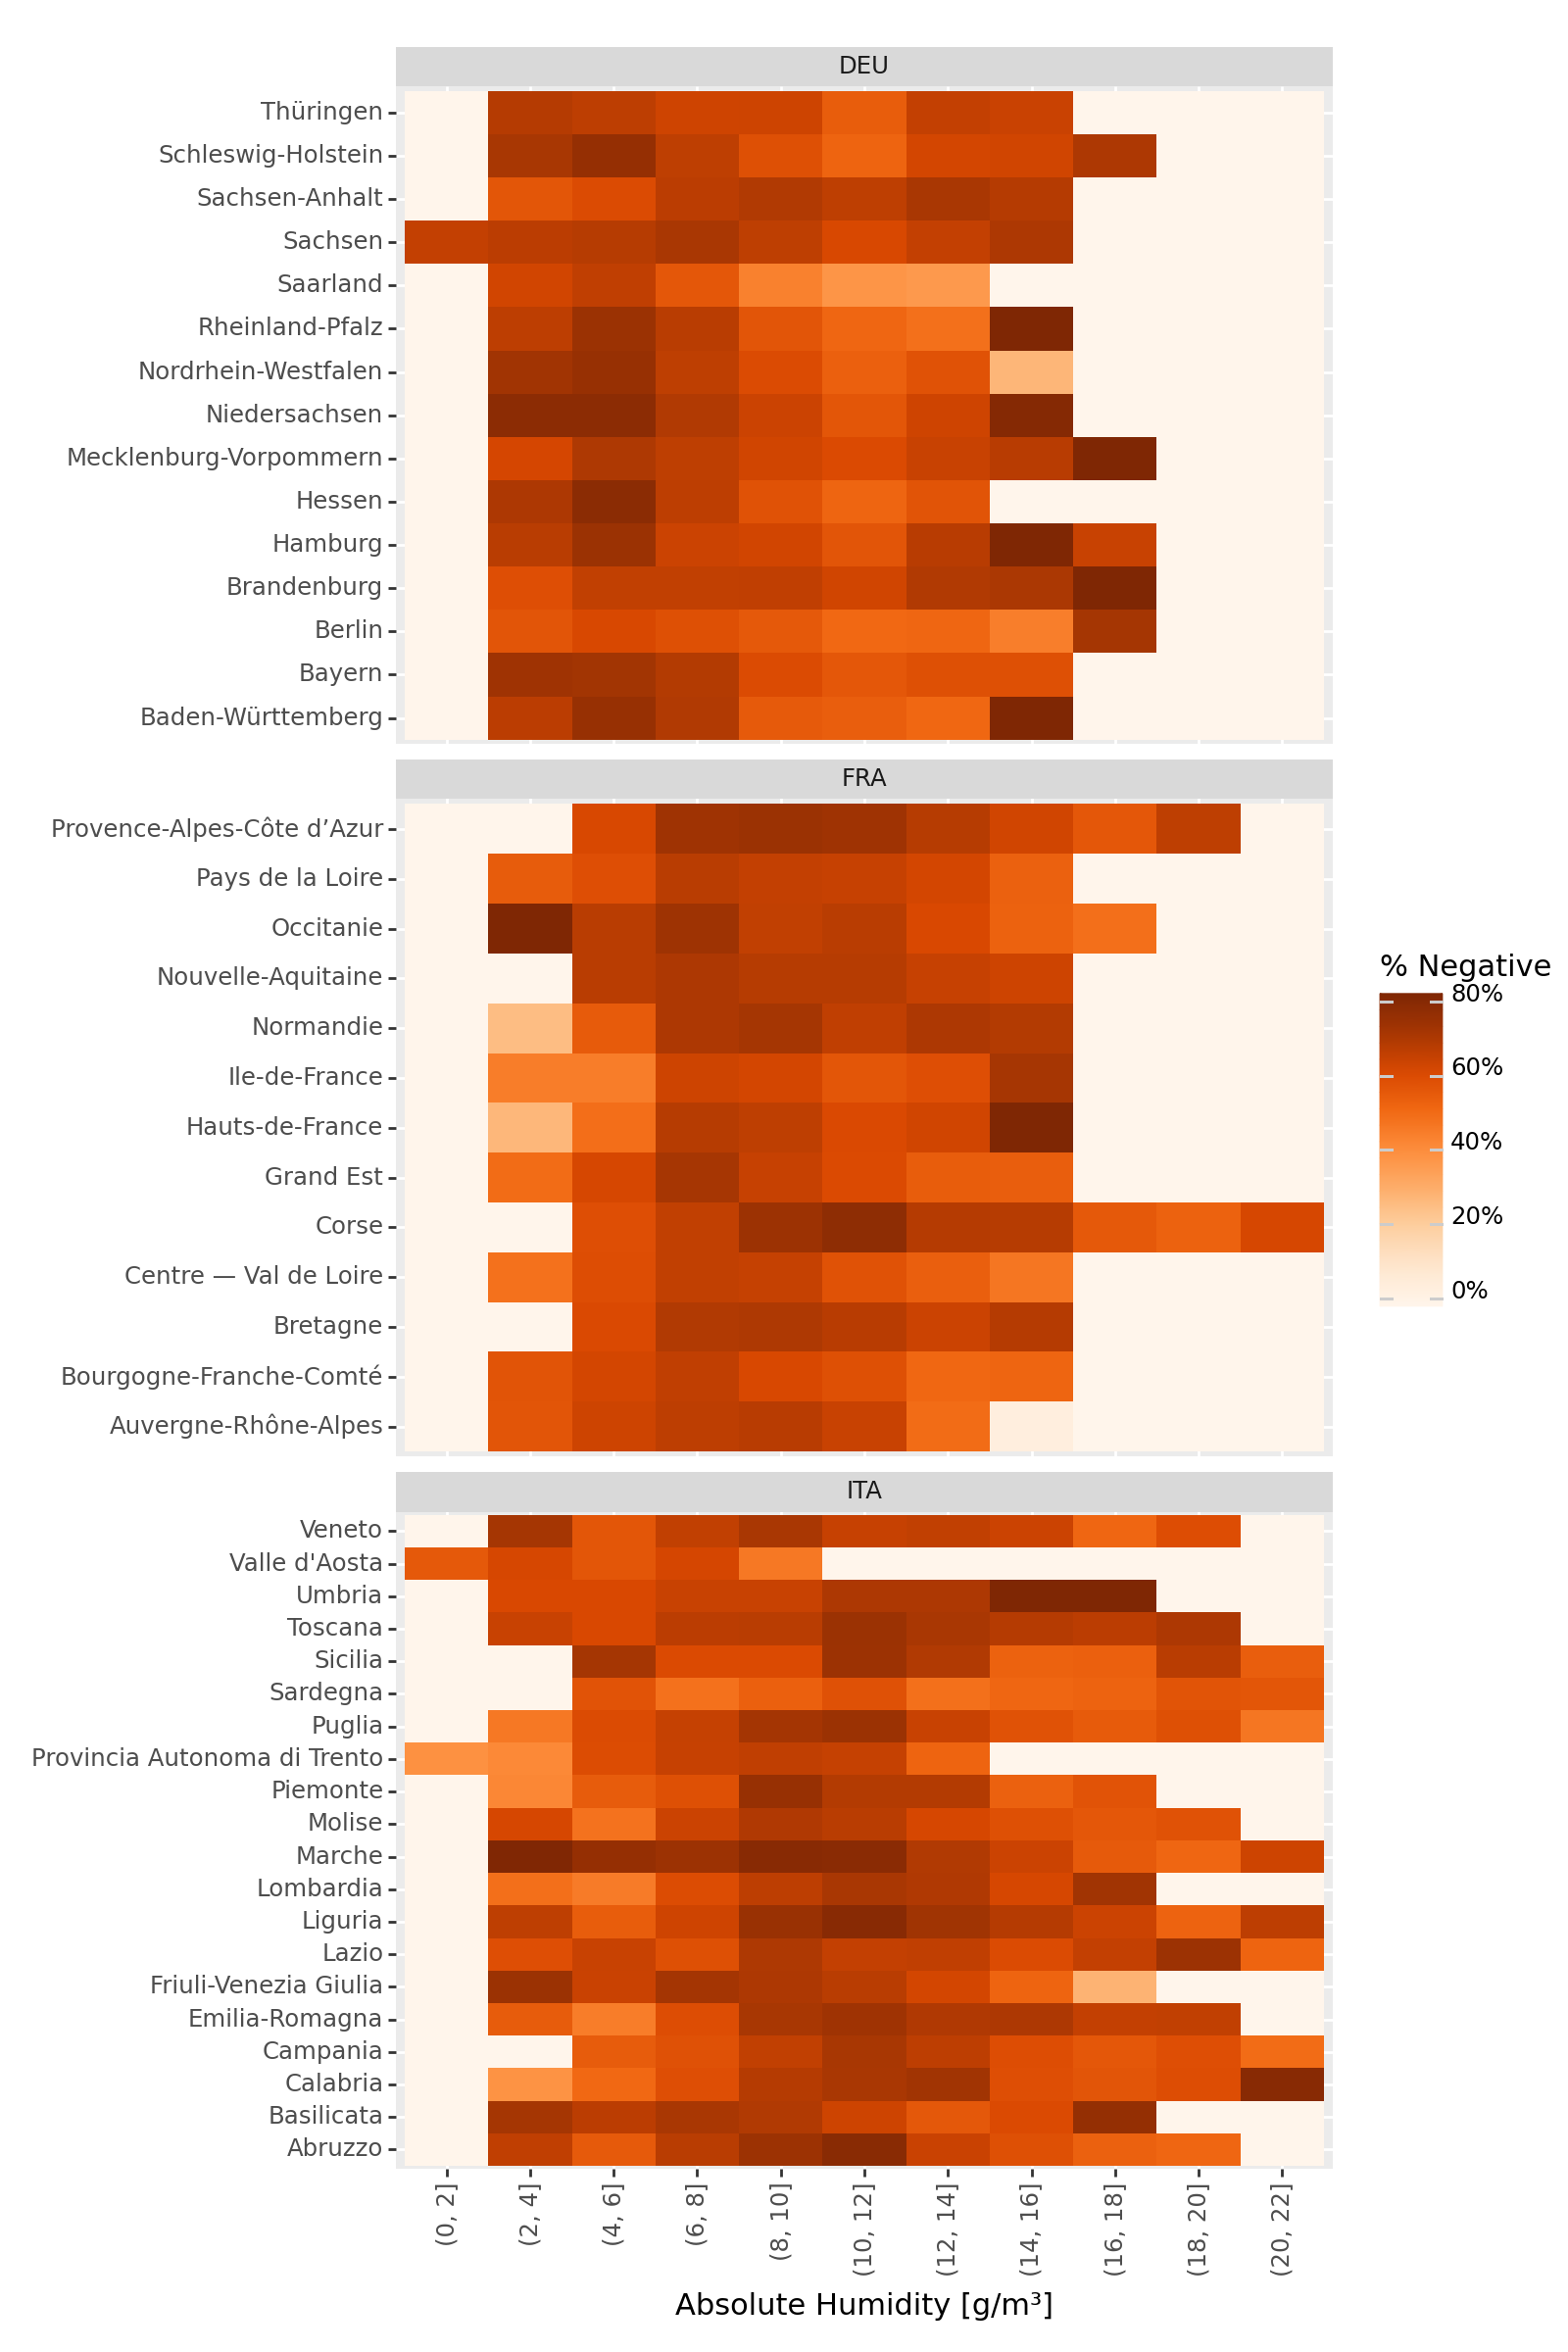

<Figure Size: (800 x 1200)>

In [67]:
wv = 'absolute_humidity'

(
    ranges_df
    .loc[lambda dd: (dd['var'] == wv)]  # Filter by variable of interest
    .groupby(['cat_value', 'region', 'country'])
    .apply(lambda x: x.assign(n=x.loc[x['direction'] != 'NS', 'counts'].sum()))  # Calculate n excluding 'NS'
    .reset_index(drop=True)
    .assign(negative=lambda dd: dd.loc[dd['direction'] == 'Negative', 'counts'] / dd['n'])  # Calculate % Negative
    .loc[lambda dd: dd['direction'] == 'Negative']  # Filter for Negative direction only
    .fillna(value={'negative': 0})  # Replace NaN with 0 for % Negative
    .pipe(lambda dd: p9.ggplot(dd)
         + p9.aes('cat_value', 'region', fill='negative')
         + p9.geom_tile()
         + p9.facet_wrap('country', ncol=1, scales='free_y')
         + p9.theme(figure_size=(8, 12), axis_text_x=p9.element_text(rotation=90))
         + p9.scale_fill_continuous('Oranges', labels=percent_format(), limits=(0, 0.8))
         + p9.labs(x=CV_LABELS[wv], fill='% Negative', y='')
         )
)